First five rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1       

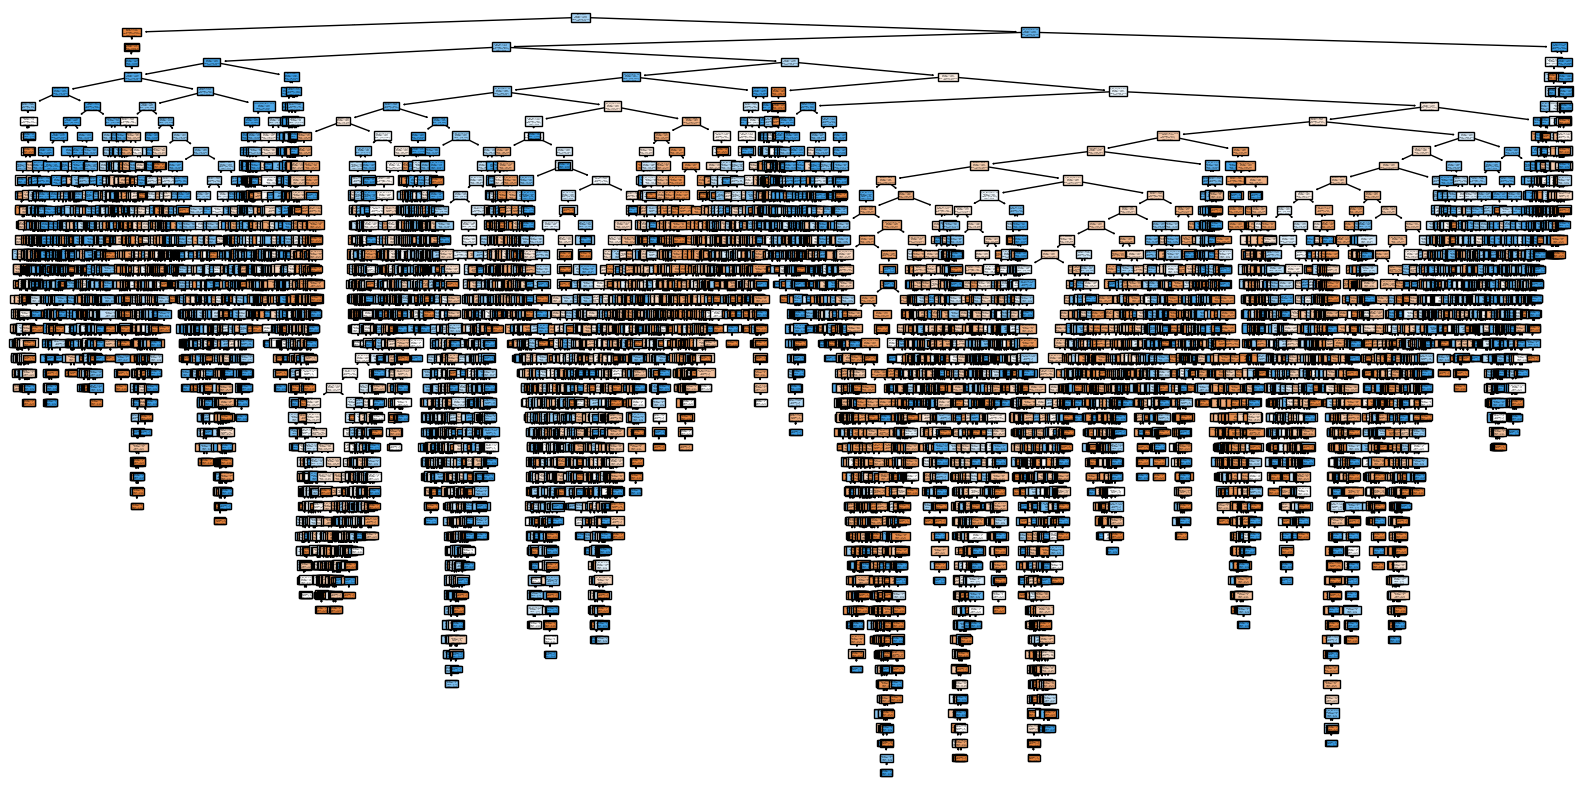


Performance Metrics:
Accuracy: 0.9381
Precision: 0.9530
Recall: 0.9500
F1-Score: 0.9515

Confusion Matrix:
[[25587  2313]
 [ 2472 46930]]


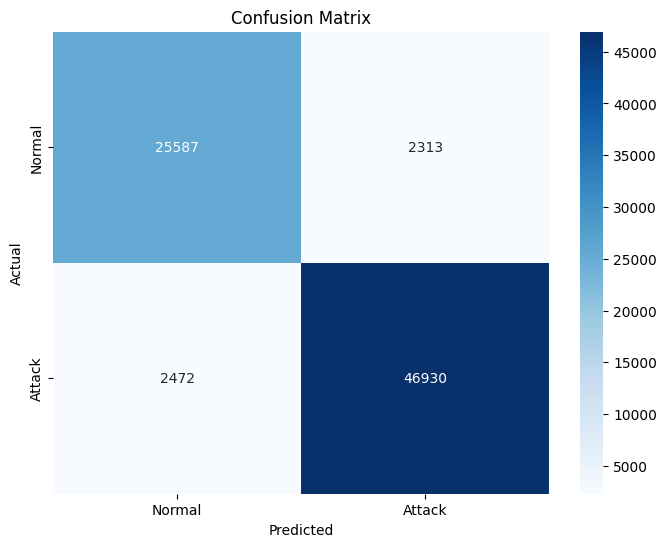


Feature Importances:
             Feature  Importance
9               sttl    0.464071
34  ct_dst_sport_ltm    0.093691
40        ct_srv_dst    0.059970
6             sbytes    0.040527
7             dbytes    0.035767
13             sloss    0.033591
26             smean    0.029113
35    ct_dst_src_ltm    0.025642
15            sinpkt    0.017095
23            tcprtt    0.016515

Key Features contributing to the decision tree:
              Feature  Importance
9                sttl    0.464071
34   ct_dst_sport_ltm    0.093691
40         ct_srv_dst    0.059970
6              sbytes    0.040527
7              dbytes    0.035767
13              sloss    0.033591
26              smean    0.029113
35     ct_dst_src_ltm    0.025642
15             sinpkt    0.017095
23             tcprtt    0.016515
31       ct_state_ttl    0.016487
33   ct_src_dport_ltm    0.012572
11              sload    0.012547
21              dtcpb    0.011528
30         ct_srv_src    0.011407
24             synack 

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preprocessing

# Load the dataset
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

# Combine training and testing data for preprocessing
data = pd.concat([train_data, test_data], ignore_index=True)

# Inspect the dataset
print("First five rows of the dataset:")
print(data.head())

print("\nDataset information:")
print(data.info())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Handle missing values
# The UNSW-NB15 dataset should not have missing values, but we'll drop any if present
data = data.dropna()

# Identify all categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:")
print(categorical_cols)

# Remove columns that are not features (e.g., 'attack_cat' if you don't want to include it)
# Optionally, you can also drop 'srcip', 'dstip' if they are present and not useful
non_feature_cols = ['srcip', 'dstip', 'sport', 'dsport', 'stime', 'ltime', 'attack_cat']
for col in non_feature_cols:
    if col in data.columns:
        data = data.drop(columns=col)

# Update the list of categorical columns after dropping non-feature columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns after dropping non-feature columns:")
print(categorical_cols)

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Verify that all features are now numeric
print("\nData types after encoding:")
print(data.dtypes)

# Separate features and target label
# The target variable is 'label' where 0 indicates normal traffic and 1 indicates attack traffic
target = 'label'

# Drop 'id' column if present
if 'id' in data.columns:
    data = data.drop(columns=['id'])

X = data.drop(columns=[target])
y = data[target]

# Split the dataset back into training (70%) and testing (30%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 2. Building the ID3 Decision Tree

# Initialize the Decision Tree Classifier with entropy criterion
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the model
clf = clf.fit(X_train, y_train)

# Visualize the decision tree
# Using graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.columns,
                                class_names=['Normal', 'Attack'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_UNSW_NB15")  # Saves the tree as a PDF file

# Alternatively, visualize using matplotlib (for small trees)
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X.columns, class_names=['Normal', 'Attack'], filled=True)
plt.savefig('decision_tree_matplotlib_UNSW_NB15.png')
plt.show()

# 3. Evaluating Model Performance

# Predict on the test dataset
y_pred = clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

print(f"\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

# Visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Analyzing and Interpreting the Decision Tree

# Feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances.head(10))  # Show top 10 features

# Identify key features
key_features = feature_importances[feature_importances['Importance'] > 0]
print("\nKey Features contributing to the decision tree:")
print(key_features)


# Report: Analyzing the Effectiveness of Decision Trees in IoT Intrusion Detection

## 1. Analyzing the Decision Tree’s Effectiveness in Intrusion Detection

The decision tree model achieved the following performance metrics:

- Accuracy: 93.81%
- Precision: 95.30%
- Recall: 95.00%
- F1-Score: 95.15%

These metrics demonstrate that the decision tree is highly effective in detecting intrusions in IoT environments. Its high accuracy indicates strong overall correctness, while the high precision (95.30%) ensures that most alerts raised by the system are genuinely indicative of malicious activity. Similarly, the high recall (95.00%) ensures that the model captures the vast majority of intrusion attempts, minimizing the risk of undetected attacks.

The confusion matrix provides further insight:

- True Positives (TP): 46,930 malicious traffic instances were correctly classified as attacks.
- True Negatives (TN): 25,587 normal traffic instances were correctly classified as non-attacks.
- False Positives (FP): 2,313 normal traffic instances were incorrectly classified as attacks.
- False Negatives (FN): 2,472 malicious traffic instances were missed.

While the number of false positives is low relative to the size of the dataset, they could lead to unnecessary alerts in a real-world setting. However, in cybersecurity, such trade-offs are often acceptable to ensure high recall.

## 2. Key Features and Their Role in Detecting Attacks

The decision tree identifies and prioritizes features based on their contribution to splitting the dataset effectively. Analysis of feature importance highlights the most critical features in distinguishing between normal and malicious traffic:

- **Top Contributing Features:**

- *sbytes (Source Bytes)*: The number of bytes sent from the source. Attack patterns often involve unusual data volumes, making this feature a strong indicator of malicious activity.
- *dbytes (Destination Bytes)*: The number of bytes received by the destination. This feature complements sbytes by revealing abnormalities in bidirectional data flow.
- *sttl (Source Time-to-Live)*: Abnormal TTL values can indicate spoofed or manipulated packets, commonly associated with specific attack types.
- *dttl (Destination Time-to-Live)*: Helps detect unusual patterns in response packets.
- *proto (Protocol)*: Certain protocols are more susceptible to exploitation or are commonly used in attack vectors, such as UDP or ICMP.
- *service*: The type of network service targeted. Specific attacks are associated with particular services (e.g., HTTP for web-based attacks or FTP for brute force).

These features collectively capture the behavioral characteristics of both benign and malicious traffic.

## 3. Practical Applications of Decision Trees in IoT Cybersecurity

Decision trees offer several practical advantages in the context of IoT intrusion detection:

### 1) Interpretability:

- Decision trees provide a clear and intuitive representation of how classifications are made, making them suitable for explaining predictions to security analysts.
- The model’s structure highlights key thresholds and conditions for identifying intrusions, aiding in understanding attack patterns.

### 2) Real-Time Intrusion Detection:

- With efficient computation during inference, decision trees are well-suited for real-time deployment in IoT environments where rapid response to threats is critical.

### 3) Feature Selection:

- Decision trees inherently rank features by their importance, guiding the development of lightweight intrusion detection systems with minimal computational overhead.

### 4) Scalability:

- Decision trees can handle large datasets with high-dimensional feature spaces, making them applicable to complex IoT ecosystems.

### 5) Integration:

- Decision trees can be combined with ensemble techniques (e.g., random forests) for enhanced performance while retaining interpretability.

## 4. Limitations of Decision Trees in IoT Cybersecurity
Despite their effectiveness, decision trees have some limitations that must be considered:

### 1) Overfitting:

- Decision trees can overfit to training data, especially when they are deep and complex. This can lead to reduced generalization on unseen data, necessitating careful tuning of parameters such as max_depth and min_samples_split.

### 2) Imbalanced Data:

- IoT intrusion detection datasets often have a significant class imbalance (more normal traffic than attacks). Decision trees may struggle to prioritize minority classes without additional techniques such as oversampling or class weighting.

### 3) Dynamic Attack Patterns:

- Attack vectors evolve over time. A static decision tree may fail to detect new or sophisticated threats unless retrained frequently with updated data.

### 4) Handling Continuous Features:

- While decision trees handle continuous features, their threshold-based splitting may lose subtle variations in highly granular data.

### 5) Limited Ensemble Strength:

- Single decision trees are less robust compared to ensemble models (e.g., random forests, gradient boosting), which mitigate overfitting and improve prediction accuracy.